### Changepoint detection using CUSUM (NIST Method)

#### Scenario 1: Sudden Drift

##### Reference:
NIST CUSUM example is at: https://www.itl.nist.gov/div898/handbook/pmc/section3/pmc323.htm


In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import dataframe_image as dfi

sns.set_style('darkgrid')
np.random.seed(42)
#

The data for CUSUM-based changepoint detection is the AUC scores which are the outcome of the MLP classifier. The classifier was first tained using data samples from one distribution (in-control) which has a classificatoin AUC of 0.86. The model was then tested with the test data drawn from the same distribution. The model was also tested with data samples drawn from another distribution (out-of-control) with classification AUC 0.80. 

To simulate the sudden drift scenario, the trained model is first tested with the random samples drawn from the in-control distribution each day for 100 days (day0-99) followed by random samples drawn from the out-of-control distribution for the next 100 days (day 100-199).

As a first step, load the data followed by train the classifier with the in-control data.

In [2]:
# Load Data - AUC 0.86 and  AUC 0.80
data86 = np.load('d0-AUC.86.npy')  #in-control  #d0-AUC.86-35k.npy
#data80 = np.load('d5-AUC.80.npy')  #out-of-control -
data80 = np.load('d0-AUC.8302.npy')  #out-of-control - CHANGE THIS FROM 0.86 to 0.83 #d0-AUC.83.npy
#print(data86.shape)
#print(data80.shape)

In [3]:
import sklearn
#print(samples.shape)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('always') 
warnings.filterwarnings('ignore')

#--------------------------------------------------------
# Train Classifier - MLP
#--------------------------------------------------------
samples = data86[:,[0,1]]
labels = data86[:,2]


X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.20, random_state=5)
print("Train",X_train.shape)
print("Test",X_test.shape)
mlp = MLPClassifier(hidden_layer_sizes=(2,4,4,1), activation='relu', solver='adam', max_iter=2000,learning_rate_init=0.001,learning_rate="constant",random_state=4,shuffle=True,batch_size=8)
mlp.fit(X_train,y_train)
predict_train = mlp.predict(X_train)
#predict_test = mlp.predict(X_test)

#Evaluate the Model
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_train,predict_train))
print(classification_report(y_train,predict_train))

tn, fp, fn, tp = confusion_matrix(y_train,predict_train).ravel()
specificity = tn / (tn+fp)

AUC = roc_auc_score(y_train,predict_train)
print("Specificity:", specificity)
print("AUC:", AUC)
#print(predict_train.shape)

Train (16800, 2)
Test (4200, 2)
[[5910 1308]
 [ 881 8701]]
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      7218
         1.0       0.87      0.91      0.89      9582

    accuracy                           0.87     16800
   macro avg       0.87      0.86      0.87     16800
weighted avg       0.87      0.87      0.87     16800

Specificity: 0.8187863674147964
AUC: 0.863421570265528


Split the out-of-control data into train/test set and draw samples from the test set for simulating the sudden drift scenario

In [4]:
# Samples from the second distribution -  (day100-199)
new_samples = data80[:,[0,1]]
new_labels = data80[:,2]

X_train, X_test80, y_train, y_test80 = train_test_split(new_samples, new_labels, test_size=0.20, random_state=3)


#predict_test_80 = mlp.predict(X_test80)

# Performance on test data
#-------------------------------------------------------------------

#print the confusion matrix and the confusion report results on the test data
#print(confusion_matrix(y_test80,predict_test_80))
#print(classification_report(y_test80,predict_test_80))
#tn, fp, fn, tp = confusion_matrix(y_test80,predict_test_80).ravel()
#specificity = tn / (tn+fp)


#AUC = roc_auc_score(y_test80,predict_test_80)
#print("Test: Specificity:", specificity)
#print("Test: AUC:", AUC)

#print(X_test80.shape)
#np.sum(y_test80)


##### Sudden Drift 
Run 1000 simulations of:
 - Day 0-99 &emsp;&nbsp;&nbsp; -  AUC 0.86 &nbsp;(in-control data)
 - Day 100-199 – AUC 0.83

Save the test AUCs for the changepoint detection using CUSUM algorithm. 

#####  Evaluate:
#False Positives, #True Positives, #False Negatives, average, minimum and maximum delay to detect the change point. Each experiment either has multiple FPs and one TP (or missed detection -> False Negatives). Once all the FPs and one TP is detected, break out of the loop.
Mean Time Between False Alarms is computed in the pre-change regime and Average Detection Delay in the post-change regime.

In [5]:
# Simulate 1000 days - Samples from AUC(0.86) from day 0-99 and AUC(0.80) from day100-199
runs = 0
FalsePos      =  np.array([])
TruePos       =  np.array([])
DelaytoDetect =  np.array([])
FAR           =  np.array([])     #False Alarm Rate
STD_test_AUCs =  np.array([])     #Standard deviation of test AUCs
#DetectionTimes=  np.array([])
DetectionTimes=  np.array([],dtype=int)
AvgDD         = np.array([])       # Average Detection Delay
while (runs < 1000):
    test_days = 0
    test_AUC =  np.array([])
    while (test_days < 100):     #day0-99 from AUC(0.86)
        test_samples = np.array([])
        test_labels = np.array([])
    

        number_of_rows = X_test.shape[0]
        random_indices = np.random.choice(number_of_rows, 
                                  size=50, 
                                  replace=False)
    
    
        test_samples = X_test[random_indices,:]
        test_labels  = y_test[random_indices]
        #test_samples.shape
        #print(y_test.shape)
        #test_labels

        predict_test = mlp.predict(test_samples)

        #print(confusion_matrix(test_labels,predict_test))
        #print(classification_report(test_labels,predict_test))
        tn, fp, fn, tp = confusion_matrix(test_labels,predict_test).ravel()
        specificity = tn / (tn+fp)


        AUC = roc_auc_score(test_labels,predict_test)
        #print("Specificity:", specificity)
        #print("AUC:", AUC)

        test_AUC = np.append(test_AUC, AUC)
        #print("day",test_days)
        #AUC
        test_days += 1
    
    while (test_days < 200):    #day100-199 from AUC(0.80)
        test_samples80 = np.array([])
        test_labels80 = np.array([])
    

        number_of_rows80 = X_test80.shape[0]
        random_indices80 = np.random.choice(number_of_rows80, 
                                  size=50, 
                                  replace=False)
    
    
        test_samples80 = X_test80[random_indices80,:]
        test_labels80  = y_test80[random_indices80]
        #test_samples.shape
        #print(y_test.shape)
        #test_labels

        predict_test80 = mlp.predict(test_samples80)

        #print(confusion_matrix(test_labels,predict_test))
        #print(classification_report(test_labels,predict_test))
        tn80, fp80, fn80, tp80 = confusion_matrix(test_labels80,predict_test80).ravel()
        specificity80 = tn80 / (tn80+fp80)


        AUC80 = roc_auc_score(test_labels80,predict_test80)
        #print("Specificity:", specificity)
        #print("AUC:", AUC)

        test_AUC = np.append(test_AUC, AUC80)
        #print("day",test_days)
        #AUC
        test_days += 1
    
    #CUSUM for day0-200: outcomes are detection delay and #FP, #TP
    num_rows = np.shape(test_AUC)[0]
    in_control_auc = test_AUC[:100]
    out_control_auc = test_AUC[100:200]
    std_auc = np.std(out_control_auc)
    x = np.array(test_AUC)

    mu   = np.mean(in_control_auc)
    mu_1 = np.mean(out_control_auc)
    std  = np.std(in_control_auc)
    std_1  = np.std(out_control_auc)
    h    = 0.21    # Upper/lower control limit to detect the changepoint
    k    = 0.03    # Drift 0.05 is the 1 sigma change we wish to detect, 0.03 - half-sigma change
    
    x_mean = np.zeros(num_rows,dtype=float)
    #S_hi : for positive changes --------------------------
    S_hi = np.zeros(num_rows,dtype=float)
    S_hi[0] = 0.0 # starts with 0
    #Increase in mean = x-mu-k ----------------------------
    mean_hi = np.zeros(num_rows,dtype=float)

    #Decrease in mean = mu-k-x----------------------------
    mean_lo = np.zeros(num_rows,dtype=float)
    #S_lo : for negative changes --------------------------
    S_lo = np.zeros(num_rows,dtype=float)
    S_lo[0] = 0.0 # starts with 0
     #CUSUM: Cumulative sum of x minus mu ------------------
    cusum = np.zeros(num_rows,dtype=float)
    cusum[0] = 0.0 # initialize with 0
    
    for i in range(0, num_rows):
        x_mean[i]  = x[i] - mu  #x_mean 
        mean_hi[i] = x[i] - mu - k
        S_hi[i]    = max(0, S_hi[i-1] + mean_hi[i])
        mean_lo[i] = mu - k - x[i]
        S_lo[i]    = max(0, S_lo[i-1] + mean_lo[i])
        cusum[i]   = cusum[i-1] + x_mean[i]

    x_mean  = np.round(x_mean,decimals=2)
    S_hi    = np.round(S_hi,decimals=2)
    mean_lo = np.round(mean_lo,decimals=2)
    S_lo    = np.round(S_lo,decimals=2)
    cusum   = np.round(cusum,decimals=2)

    # Construct the tabular CUSUM Chart
    chart = np.array([])
    chart = np.column_stack((x.T, x_mean.T, mean_hi.T, S_hi.T, mean_lo.T, S_lo.T, cusum.T))
    np.round(chart, 2)

    #d = 2 *(np.log((1-0.01) / (0.0027)))
    #h = d * 0.5 # h= d*k where k=0.5
    #h = 4 # as per the NIST doc on CUSUM

    #l1 =  np.append(num_rows, data_tabular, axis = 1)
    #l1 = np.concatenate(num_rows.T, data_tabular.T)
    #chart = np.column_stack((num_rows.T, data_tabular.T))
    #chart

    np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format})
    #print("CUSUM Chart is:\n", np.round(chart,decimals=2))
    #x_mean

    df = pd.DataFrame(chart) 
    df.columns = ['X','x-mu','Increase in Mean', 'S_hi', 'Decrease-in-mean', 'S_lo', 'CUSUM']
    #filename = "file%d" %runs
    #df.to_csv(("CUSUM-out/file%d.csv" %runs), sep='\t')    
    #print(df.to_string())
    #print(chart)
    #Export datafrae to png
    #import dataframe_image as dfi
    #dfi.export(df,'CUSUM-out/CUSUM-run.png')
    
    
    # False positives and Total alarms
    falsePos = 0
    alarms   = 0
    delay    = 0
    avddd    = 0   # this is the delay from the paper: td-ts (z_k-v) where v is the changepoint and z_k is the time of detection
    #MTBFA    = 0
    
    
    for i in range(0, num_rows):
        if (S_lo[i] > h):   
            if (i<100):
                falsePos += 1  #False Positives 
                #print("time false alarm",i)
                DetectionTimes= np.append(DetectionTimes, i)   #time at which a false positive is detected
                #print("detection times",DetectionTimes)
                #print("detection times size",DetectionTimes.size)
            #break
        #if (S_lo[i] > h):   
            #if (i>100):  
                #alarms += 1        #True Positive: break after detecting one TP
                #delay   = i-100+1    # ts is 100 because the change starts at day100
                #avddd   = i-100
            #break

    # Delay to detect the first changepoint
    #delay = 0
    for i in range(0, num_rows):
           if (S_lo[i] > h) and (i>99):
                    alarms += 1        #True Positive: break after detecting one TP
                    delay  = i-100+1    # ts is 100 because the change starts at day100
                    avddd  = i-100
                    break
    
    #Calculate MTBFA(Mean time time between False Alarms)
    #MTBFA = np.mean(DetectionTimes)
    #FlaseAlarmRate = 1/MTBFA
    
    FalsePos      = np.append(FalsePos, falsePos)
    TruePos       = np.append(TruePos, alarms)
    DelaytoDetect = np.append(DelaytoDetect, delay)   # td-ts+1
    #FAR           = np.append(FAR, FlaseAlarmRate)
    #DetectionTimes= np.append(DetectionTimes, detectionTime)
    AvgDD         = np.append(AvgDD, avddd)   # ADD estimate from the paper
    STD_test_AUCs = np.append(STD_test_AUCs, std_auc)
    #print(falsePos)
    runs += 1  # continue until 1000 runs


Calculate the False Positives, True Positives, Average Detection Delay and False Positive Rate

In [26]:
#test_AUC.shape
#num_rows = np.shape(test_AUC)[0]
#num_rows
#in_control_auc = test_AUC[:100]
#in_control_auc.shape
#x = np.array(test_AUC)
#test_AUC.shape
#x.shape
print("total number of False Positives:",np.sum(FalsePos))
print("Total True Positives:",np.sum(TruePos))
print("Average Detection Delay",np.mean(AvgDD))
print("Minimum Delay",np.min(AvgDD))
print("Maximum Delay",np.max(AvgDD))
MTBFA = np.mean(DetectionTimes)
FlaseAlarmRate = 1/MTBFA
print("MTBFA", MTBFA)
print("Flase Alarm Rate", FlaseAlarmRate)
nonZeroAvgDD = AvgDD[np.nonzero(AvgDD)]
#print("Average Detection Delay, ADD from paper is",np.mean(nonZeroAvgDD))
print("standard deviations of the test AUCs is",np.mean(STD_test_AUCs))
# Compute Average Run Length (ARL)
# ARL = 
#AvgDD

total number of False Positives: 292.0
Total True Positives: 997.0
Average Detection Delay 17.511
Minimum Delay 0.0
Maximum Delay 98.0
MTBFA 60.513698630136986
Flase Alarm Rate 0.016525183927560836
standard deviations of the test AUCs is 0.05353071375013393


#### Comput the Average Run Length

In [15]:
import math
#DetectionTimes
std
out_control_auc = test_AUC[100:200]
mu_1=np.mean(out_control_auc)
k=(mu_1-mu)/2
delta_star=(mu_1-mu)/std
delta_star
10+1.166
-1.58+0.03
ARL_plus = (math.exp(2*1.55*6.166) + (2*-1.55*6.166) - 1 )/(2*pow(1.55,2))
ARL_plus
ARL_minus = (math.exp(-2*1.61*6.166) + (2*1.61*6.166) - 1 )/(2*pow(1.61,2))
ARL_minus
ARL = pow((1/ARL_plus + 1/ARL_minus),-1)
ARL
FAR = 1/ARL
#FAR
print("ARL+",ARL_plus)
print("ARL-",ARL_minus)
print("ARL", ARL)
print("FAR", FAR)
mu_1

ARL+ 41655453.61255742
ARL- 3.636919872378365
ARL 3.6369195548404716
FAR 0.2749579650913845


0.8255101624378137

Troubleshooting

In [21]:
#timetoDetect
#FalsePos
#falsePos
DelaytoDetect
#TruePos
#AvgDD
#DetectionTimes.size()

#for i in range(0, 1000):
    #if TruePos[i] == 0:
        #print(i)
        
        
#mu_1 
#std_1  = np.std(out_control_auc)
#std_1
#test_labels80.shape
#TruePos
#nonZeroAvgDD

array([20.00, 40.00, 0.00, 33.00, 46.00, 0.00, 79.00, 44.00, 0.00, 47.00,
       22.00, 14.00, 48.00, 0.00, 0.00, 0.00, 51.00, 0.00, 82.00, 12.00,
       67.00, 37.00, 18.00, 61.00, 8.00, 6.00, 13.00, 0.00, 20.00, 47.00,
       36.00, 0.00, 43.00, 10.00, 69.00, 8.00, 29.00, 53.00, 0.00, 29.00,
       50.00, 33.00, 14.00, 37.00, 76.00, 45.00, 0.00, 0.00, 15.00, 20.00,
       30.00, 61.00, 17.00, 26.00, 23.00, 24.00, 15.00, 42.00, 82.00,
       0.00, 64.00, 80.00, 0.00, 0.00, 69.00, 5.00, 21.00, 13.00, 45.00,
       77.00, 16.00, 31.00, 53.00, 0.00, 53.00, 30.00, 3.00, 45.00, 15.00,
       34.00, 70.00, 74.00, 0.00, 57.00, 79.00, 0.00, 0.00, 0.00, 20.00,
       49.00, 20.00, 62.00, 0.00, 68.00, 0.00, 68.00, 21.00, 97.00, 12.00,
       25.00, 18.00, 15.00, 38.00, 0.00, 83.00, 98.00, 5.00, 13.00, 38.00,
       16.00, 17.00, 69.00, 30.00, 50.00, 33.00, 14.00, 24.00, 40.00,
       11.00, 63.00, 16.00, 13.00, 21.00, 60.00, 0.00, 18.00, 5.00, 15.00,
       39.00, 15.00, 63.00, 15.00, 96.00, 71

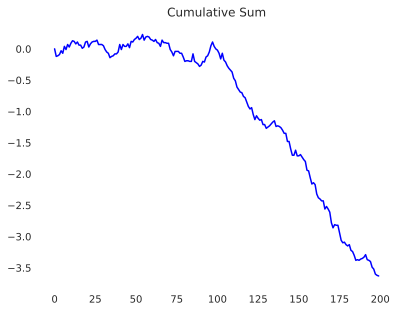

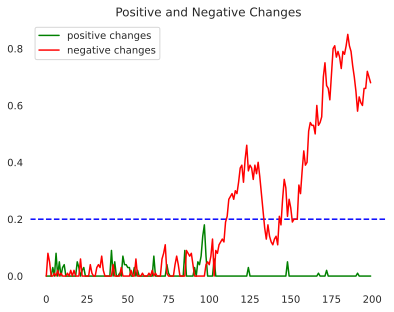

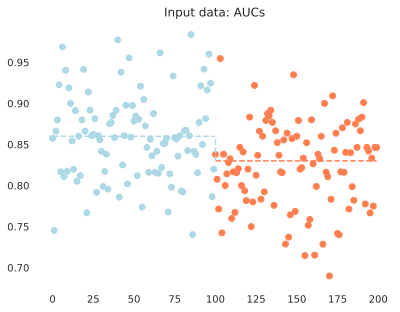

In [24]:
#CUSUM
plt.plot(cusum, '-b')
plt.title('Cumulative Sum')
plt.show()

# specifying horizontal line type
plt.axhline(y = 0.2, color = 'b', linestyle = '--')
plt.plot(S_hi,  '-g', label='positive changes')
plt.plot(S_lo, '-r', label='negative changes')
plt.title('Positive and Negative Changes')
plt.legend()
plt.show()

#Plot the AUCs
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(b=None)
y1 = np.arange(100)
x1 = test_AUC[:100]
plt.scatter(y1, x1, c='lightblue')
y2 = np.arange(100, 200, 1)
x2 = test_AUC[100:200]
plt.scatter(y2, x2, c='coral')
plt.hlines(y = 0.86, xmin=0, xmax=99,color = 'lightblue', linestyle = '--')
plt.hlines(y = 0.83, xmin=100, xmax=199,color = 'coral', linestyle = '--')
# single vline with specific ymin and ymax
plt.vlines(x=100, ymin=0.83, ymax=0.86, colors='lightblue', linestyle = '--')
#yline(0.86)
#plt.plot(test_AUC, 'go')


plt.title('Input data: AUCs')
plt.show()